# ID Card prediction test

This notebook demonstrates a test with 4 example ID Cards. The previously trained model "model.h5" is loaded and a prediction is made. The prediction is a mask of the ID Card on the picture. Then a corner detection and 4 point transformation is performed on the mask to get a frontal view of the ID Card.

In [1]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_ubyte
from matplotlib import gridspec
from keras.models import load_model

from utils import image
from utils import metrics

IMPORT_FILES = "./test/*.png"
MODEL_FILE = "model.h5"

#### Helper functions

In [2]:
def load_data(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = img / 255.0
    height, width = img.shape[:2]
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    img = img.reshape(1, 256, 256, 1)
    return img, height, width

### Preprocessing

Load sample .png images from ./test/ folder and create a dictionary with the raw image and the required data for prediction.

In [3]:
images_dict = []
for file_path in glob.glob(IMPORT_FILES):
    raw = cv2.imread(file_path)
    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    img, h, w = load_data(file_path)
    images_dict.append({"raw": raw, "data": img, "height": h, "width": w})        

In [4]:
gs = gridspec.GridSpec(1, len(images_dict))

Show sample images.

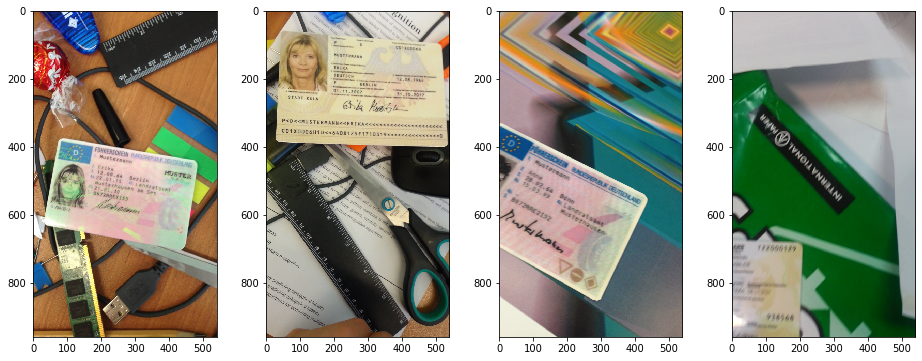

In [5]:
fig = plt.figure(figsize=(16, 6))
for n in range(len(images_dict)):
    ax = fig.add_subplot(gs[n])
    ax.imshow(images_dict[n]["raw"])

### Prediction
##### Load the Model

In [6]:
model = load_model(MODEL_FILE, custom_objects={'mean_iou': metrics.mean_iou})

Execute prediction for all sample images and store the predicted mask in the dictionary.

In [7]:
for n in range(len(images_dict)):
    data = images_dict[n]    
    data["prediction"] = model.predict(data["data"])[0]
    img = cv2.resize(data["prediction"], (data["width"], data["height"])) 
    img = img_as_ubyte(img)    
    data["mask"] = cv2.threshold(np.array(img), 200, 255, cv2.THRESH_BINARY)[1]

Show predicted images.

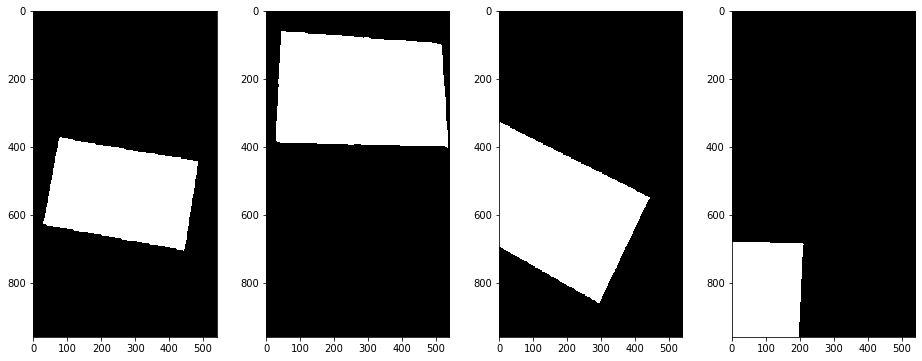

In [8]:
fig = plt.figure(figsize=(16, 6))
for n in range(len(images_dict)):
    ax = fig.add_subplot(gs[n])
    data = images_dict[n]
    ax.imshow(data["mask"], cmap="gray")    

# Result

Do the 4 point transformation and show the final result images.


ID Card not found.
ID Card not found.


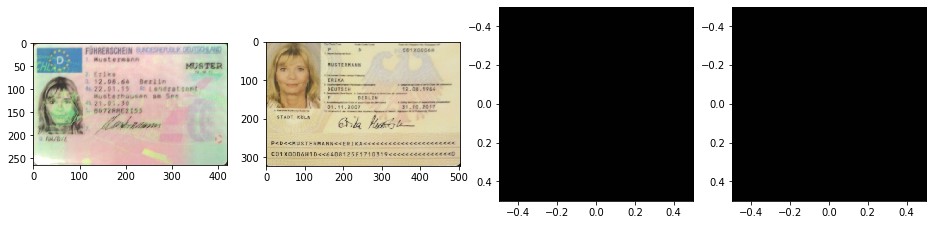

In [9]:
fig = plt.figure(figsize=(16, 6))
for n in range(len(images_dict)):
    ax = fig.add_subplot(gs[n])
    data = images_dict[n]    
    res = image.convert_object(data["mask"], data["raw"])
    if res is None:
        res = np.ones((1,1,3), np.uint8)
    ax.imshow(res)